In [1]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import sys
import glob
import hdf5storage
from random import shuffle
import time
import os
import json
import cv2
import pandas as pd

In [2]:
def functionfilenameandpath(path='./',extension='.csv'):
    # Path is the path where you want to search

    # this is the extension you want to detect


    filepaths=[]
    filenames=[]

    # print(path)

    for root, dirs_list, files_list in os.walk(path):
        # print("root",root)
        # print("dirs_list",dirs_list)
        # print("files_list",files_list)
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension:
                file_name_path = os.path.join(root, file_name)
                # if(file_name.find('Home')!=-1):
                #     filenames.append(file_name)
                #     filepaths.append(file_name_path)
                filenames.append(file_name)
                filepaths.append(file_name_path)
                # print(file_name)
                # print(file_name_path)   # This is the full path of the filter file

   
    return filenames,filepaths

In [3]:
folderpath="./2023-03-01-Test1/"
vd_ts_filenames,vd_ts_filepaths=functionfilenameandpath(folderpath,'.txt')

vd_ts_filenames.sort()
vd_ts_filepaths.sort()
print(vd_ts_filenames)

['VideoTimestamp_Test1ArmsUp1643.txt', 'VideoTimestamp_Test2ArmsYShape1647.txt', 'VideoTimestamp_Test3ArmsLow1652.txt', 'VideoTimestamp_Test4NutralRight..txt', 'VideoTimestamp_Test5NutralLeft.txt', 'VideoTimestamp_Test6NutralCentre.txt', 'VideoTimestamp_Test7Sitting.txt', 'VideoTimestamp_Test8MultiPose..txt']


In [4]:
folderpath="./2023-03-01-Test1/"
csi_filenames,csi_filepaths=functionfilenameandpath(folderpath,'.npy')

csi_filenames.sort()
csi_filepaths.sort()
print(csi_filenames)

['CSI_Test1-ArmsUp1643.npy', 'CSI_Test2ArmsYShape1647.npy', 'CSI_Test3ArmsLow1652.npy', 'CSI_Test4NutralRight.npy', 'CSI_Test5NutralLeft.npy', 'CSI_Test6NutralCentre.npy', 'CSI_Test7Sitting.npy', 'CSI_Test8MultiPose.npy']


In [5]:
folderpath="./2023-03-01-Test1/"
video_filenames,video_filepaths=functionfilenameandpath(folderpath,'.mp4')

video_filenames.sort()
video_filepaths.sort()
print(csi_filenames)

['CSI_Test1-ArmsUp1643.npy', 'CSI_Test2ArmsYShape1647.npy', 'CSI_Test3ArmsLow1652.npy', 'CSI_Test4NutralRight.npy', 'CSI_Test5NutralLeft.npy', 'CSI_Test6NutralCentre.npy', 'CSI_Test7Sitting.npy', 'CSI_Test8MultiPose.npy']


In [6]:
folderpath="./2023-03-01-Test1/"
pose_filenames,pose_filepaths=functionfilenameandpath(folderpath,'.json')

pose_filenames.sort()
pose_filepaths.sort()
print(pose_filenames)

['AlphaPose_video_Test1ArmsUp1643.json', 'AlphaPose_video_Test2ArmsYShape1647.json', 'AlphaPose_video_Test3ArmsLow1652.json', 'AlphaPose_video_Test4NutralRight.json', 'AlphaPose_video_Test5NutralLeft.json', 'AlphaPose_video_Test6NutralCentre.json', 'AlphaPose_video_Test7Sitting.json', 'AlphaPose_video_Test8MultiPose.json']


In [7]:
def compute_jmatrix_label(frame_number, json_file_name="alphapose-videoslice30-results.json"):
    # Opening JSON file
    f = open(json_file_name)


    # returns JSON object as 
    # a dictionary
    data = json.load(f)


    # Closing file
    f.close()
    frame=str(frame_number)+".jpg"

    xyc=data[frame]["people"][0]["pose_keypoints_2d"].copy()

    jointsvectorx=[]
    jointsvectory=[]
    jointsvectorc=[]
    i=0
    while(i<len(xyc)):
        jointsvectorx.append(xyc[i])
        i=i+1
        jointsvectory.append(xyc[i])
        i=i+1
        jointsvectorc.append(xyc[i])
        i=i+1
        if(i==(len(xyc))):
            break
    n = 18
    m = 18
    jointsmatrixx=[[10] * m for i in range(n)]
    jointsmatrixy=[[10] * m for i in range(n)]
    jointsmatrixc=[[10] * m for i in range(n)]

    for r in range(18):
        for c in range(18):
            if r==c:
                jointsmatrixx[r][c]=jointsvectorx[r]
                jointsmatrixy[r][c]=jointsvectory[r]
                jointsmatrixc[r][c]=jointsvectorc[r]
            else:
                jointsmatrixx[r][c]=jointsvectorx[r]-jointsvectorx[c]
                jointsmatrixy[r][c]=jointsvectory[r]-jointsvectory[c]
                jointsmatrixc[r][c]=jointsvectorc[r]*jointsvectorc[c]
    
    matx=np.array(jointsmatrixx)
    maty=np.array(jointsmatrixy)
    matc=np.array(jointsmatrixc)
    jointsmatrix=np.stack((matx,maty,matc,matc),axis=0)

    jointsvector=jointsvectorx+jointsvectory+jointsvectorc+jointsvectorc
    jointsvector=np.array(jointsvector)

    # print(len(jointsvectorx))
    # print(len(jointsvectory))
    # print(len(jointsvectorc))
    # print(len(xyc))
    # print(jointsmatrix.shape)
    # print(jointsmatrix[:,0,0])
    # print(jointsvector.shape)
    # for i in range(36,54):
    #     print(jointsvector[i],end=",")
    #     print()
    # for i in range(54,72):
    #     print(jointsvector[i],end=",")
    #     print()
    



    jmatrix_label_mod = torch.zeros(1, 4, 18, 18)
    jmatrix_label_mod[0, :, :, :] = torch.from_numpy(jointsmatrix).type(torch.FloatTensor)
    #print(jmatrix_label_mod.shape)

    return jmatrix_label_mod

In [8]:
def return_dict_for_each_session(session_no=0):
    
    csi_np=np.load(csi_filepaths[session_no],allow_pickle=True)
    data_dict={}
    data_dict_list=[]
    vd_ts=pd.read_csv(vd_ts_filepaths[session_no],names=["DateTime"])
    video_timestamps=vd_ts[:602].copy()

    vt_np=video_timestamps["DateTime"].to_list()

    set_list=[]

    jump_number=5
    i=0
    start_from=80
    index=0
    while(True):
        start_index=i*jump_number+start_from
        if start_index>(len(vt_np)-1):
            break

        
        x,y=csi_np.shape
        min=0
        for ct in range(x):
            t1=np.datetime64(vt_np[start_index])
            t2=np.datetime64(csi_np[ct][1])+np.timedelta64(11, 'h')

            if(t2<t1):
                min=ct
            if(t2-t1==0):
                min=ct
            if(t2>t1):
                break
        if(ct+1>x):
            break
        
        set_list.append([start_index,min-1,min,min+1])

        i=i+1

    
    torch.cuda.empty_cache()

    #print(set_list)
    for i in range(len(set_list)):
        data_dict={}
        csi_arr = csi_np[set_list[i][1]][2][0:50] + csi_np[set_list[i][2]][2][0:50] + csi_np[set_list[i][3]][2][0:50]
        csi_arr=np.array(csi_arr)[0:150]
        csi_arr=np.absolute(csi_arr)
        jmatrix_one=compute_jmatrix_label(set_list[i][0],pose_filepaths[session_no])
        frame=cv2.imread(video_filepaths[session_no].replace(".mp4","")+"/frame"+str(set_list[i][0])+".jpg",0)
        data_dict["csi_data"]=csi_arr
        data_dict["jmatrix"]=jmatrix_one
        data_dict["frame"]=frame
        data_dict["set_list"]=set_list[i]
        data_dict["Video_file_name"]=video_filenames[session_no]
        data_dict_list.append(data_dict)
    return data_dict_list
    

        
    

In [9]:
all_train_data=[]
for i in range(len(csi_filenames)):
    all_train_data+=(return_dict_for_each_session(i))

# Test Script

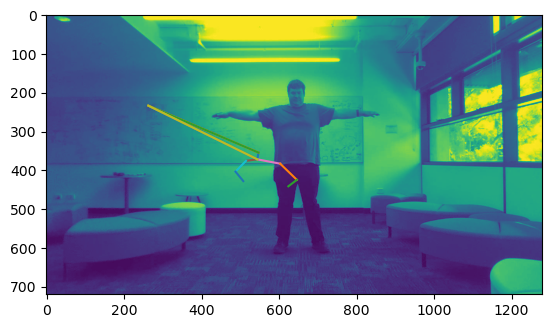

-1

In [11]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import sys
import glob
import hdf5storage
from random import shuffle
import time
import os
import cv2

limb = np.array([[0,1],[0,14],[0,15],[14,16],[15,17],[1,2],[1,5],[1,8],[1,11],[2,3],[3,4],[5,6],[6,7],[8,9],[9,10],[11,12],[12,13]])





csi_data = torch.zeros(1, 30*5, 3, 3)

# frame = frame[...,::-1]

index_to_test=30

csi_data[0,:,:,:]=torch.from_numpy(all_train_data[index_to_test]["csi_data"].reshape(150,1,1))

frame=all_train_data[index_to_test]["frame"]


wisppn = torch.load('weights/wisppn-20190226.pkl')
wisppn = wisppn.cuda().eval()

csi_data = Variable(csi_data.cuda())
pred_xy = wisppn(csi_data)
pred_xy = pred_xy.cpu().detach().numpy()

poseVector_x = np.zeros((1,18))
poseVector_y = np.zeros((1,18))
for index in range(18):
    poseVector_x[0,index] = pred_xy[0,0,index,index]
    poseVector_y[0,index] = pred_xy[0,1,index,index]

plt.imshow(cv2.resize(frame, (1280, 720)))

for i in range(len(limb)):
    plt.plot(poseVector_x[0, [limb[i, 0], limb[i, 1]]], poseVector_y[0,[limb[i, 0], limb[i, 1]]])

plt.show()
cv2.waitKey(15)

